### У нас есть реляционная база данных для управления продажами в велосипедных магазинах.
#### База данных имеет следующую структуру: 

![relations](relations.png)

https://www.kaggle.com/datasets/dillonmyrick/bike-store-sample-database/data

### Развернем базу данных на облачном SQL-сервере supabase и подсоединим к jupyter notebook

In [6]:
import os
from supabase import create_client, Client
from dotenv import load_dotenv

load_dotenv(override=True)
url = os.getenv('SUPABASE_URL')
key = os.getenv('SUPABASE_KEY')

supabase = create_client(url, key)

Список запросов (для удобства)

| № | Название запроса | Основные SQL операторы, используемые в запросе |
|---|------------------|------------------------|
| 1 | MAU | `SELECT`, `DATE_TRUNC`, `COUNT(DISTINCT)`, `GROUP BY`, `ORDER BY` |
| 2 | Расчет AOV, ARPU, ARPPU | `WITH` (CTE), `SELECT`, `JOIN`, `SUM`, `COUNT`, `ROUND`, `GROUP BY` |
| 3 | Cancel Rate | `SELECT`, `DATE_TRUNC`, `COUNT FILTER(WHERE)`, `ROUND`, `GROUP BY` |
| 4 | Распределение статусов заказов | `SELECT`, `CASE`, `DATE_TRUNC`, `COUNT`, `GROUP BY` |
| 5 | Создание представления Top_View | `CREATE OR REPLACE VIEW`, `WITH`, `SELECT`, `LEFT JOIN`, `SUM`, `EXISTS` |
| 6 | Топ-15 продаваемых товаров | `SELECT`, `ORDER BY`, `LIMIT` |
| 7 | Топ-15 товаров по выручке | `SELECT`, `CONCAT`, `ORDER BY`, `LIMIT` |
| 8 | Товары в топе и по выручке и количеству | `INTERSECT`, `SELECT`, `LIMIT`, `ORDER BY` |
| 9 | Выручка по категориям | `SELECT`, `SUM`, `ROUND`, `GROUP BY` |
| 10 | Бренды с выручкой выше среднего | `SELECT`, `GROUP BY`, `HAVING`, `AVG`, подзапрос |
| 11 | Количество подчиненных у менеджеров | `WITH`, `SELECT`, `LEFT JOIN`, `COUNT`, `GROUP BY` |
| 12 | Статус сотрудников | `SELECT`, `CASE`, подзапрос, `ORDER BY` |
| 13 | Анализ сроков доставки | `SELECT`, `DATE_TRUNC`, `AVG`, `ROUND`, `GROUP BY` |
| 14 | Retention | `WITH`, `SELECT`, `DISTINCT`, `MIN OVER()`, `COUNT`, `ROUND` |
| 15 | Rolling Retention | `WITH` (несколько CTE), `SELECT`, `COUNT DISTINCT`, `CASE`, оконные функции |
| 16 | Товары, которые покупают вместе чаще всего | `WITH`, `SELECT`, `JOIN`, `COUNT`, `LEFT JOIN`, `LIMIT` |
| 17 | Информация о покупателях | `WITH`, `SELECT`, `LEFT JOIN`, `SUM`, `COUNT`, `ROUND`, `GROUP BY` |

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [63]:
# 1
# MAU
query=\
'''
SELECT store_id,
        DATE_TRUNC('month', order_date)::DATE AS month,
        COUNT(DISTINCT customer_id) AS MAU
FROM orders
GROUP BY DATE_TRUNC('month', order_date), store_id
ORDER BY store_id, month
'''

#-------------------------------------------------------------------------------------------------------------------------------

response = supabase.rpc('exec_sql', {'query_text': query}).execute()
mau_df = pd.DataFrame(response.data, columns=['store_id', 'month', 'mau'])
mau_df['month'] = mau_df.month.astype('datetime64[ns]')
print(mau_df.head())

   store_id      month  mau
0         1 2016-01-01   14
1         1 2016-02-01   10
2         1 2016-03-01   10
3         1 2016-04-01   12
4         1 2016-05-01    8


In [64]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

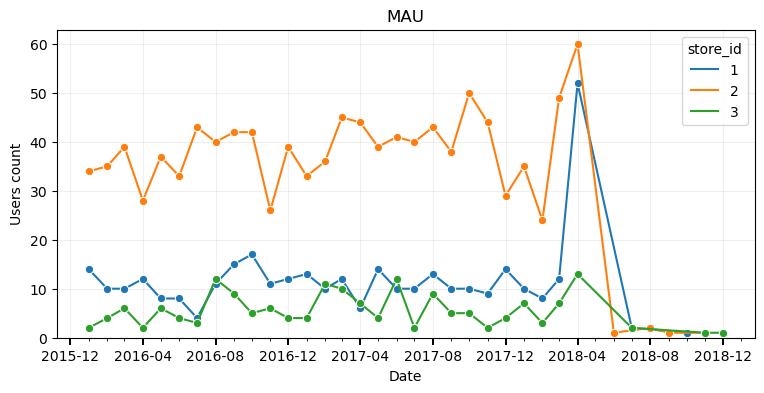

In [84]:
import matplotlib.dates as mdates

plt.figure(figsize=(9, 4))
sns.lineplot(mau_df, x='month', y='mau', hue='store_id', palette='tab10', marker='o')

ax = plt.gca()
# Основные деления и подписи каждые 4 месяца
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.tick_params(axis='x', which='major', length=5, width=1.4,)       
# Второстепенные деления каждый месяц
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))

plt.title('MAU')
plt.xlabel('Date')
plt.ylabel('Users count')
plt.ylim(0)
plt.grid(alpha=0.2)
plt.show()

### Рассчет AOV, ARPU, ARPPU для каждого магазина за месяц

In [101]:
# 2
# AOV, ARPU, ARPPU
query =\
'''
-- Найдем выручку с каждого заказа
with Orders_revenue_t AS (
  SELECT order_id,
          SUM(quantity * list_price * (1 - discount)) AS order_revenue
  FROM order_items
  GROUP BY order_id 
),
-- Рассчитаем для каждого магазина выручку, количество заказов и активных пользователей за месяц  
Res_t AS (
        SELECT 
        a.store_id,
        DATE_TRUNC('month', a.order_date)::DATE AS month,
        SUM(b.order_revenue) AS revenue,
        COUNT(a.order_id) AS orders_count,
        COUNT(DISTINCT a.customer_id) AS active_users_count

        FROM (SELECT order_id,
                order_date,
                customer_id,
                store_id              
                FROM orders
                WHERE order_status = 4) a -- выбираем только успешно доставленные заказы
        JOIN Orders_revenue_t b
        ON a.order_id = b.order_id
        GROUP BY a.store_id, DATE_TRUNC('month', a.order_date)
        )

-- Присоединим общее количество пользователей в месяце и рассчитаем искомые метрики
SELECT r.store_id,
        r.month,
        r.revenue,
        ROUND(r.revenue::DECIMAL / r.orders_count, 2) AS AOV,
        ROUND(r.revenue::DECIMAL / r.active_users_count, 2) AS ARPPU,
        ROUND(r.revenue::DECIMAL / u.users_count, 2) AS ARPU
        
FROM Res_t r
LEFT JOIN 
        (SELECT store_id,
                DATE_TRUNC('month', order_date)::DATE AS month,
                COUNT(DISTINCT customer_id) AS users_count
        FROM orders
        GROUP BY DATE_TRUNC('month', order_date), store_id
        ORDER BY store_id, month) u
ON r.store_id = u.store_id AND r.month = u.month

'''
#-------------------------------------------------------------------------------------------------------------------------------

response = supabase.rpc('exec_sql', {'query_text': query}).execute()
df1 = pd.DataFrame(response.data, columns=['store_id', 'month', 'revenue', 'aov', 'arpu', 'arppu'])
df1['month'] = df1.month.astype('datetime64[ns]')
print(df1.head())

   store_id      month     revenue      aov     arpu    arppu
0         1 2016-01-01  71760.3064  5125.74  5125.74  5125.74
1         1 2016-02-01  35255.4513  3525.55  3525.55  3525.55
2         1 2016-03-01  46817.6251  4681.76  4681.76  4681.76
3         1 2016-04-01  31980.6586  2907.33  2665.05  2907.33
4         1 2016-05-01  28095.2399  3511.90  3511.90  3511.90


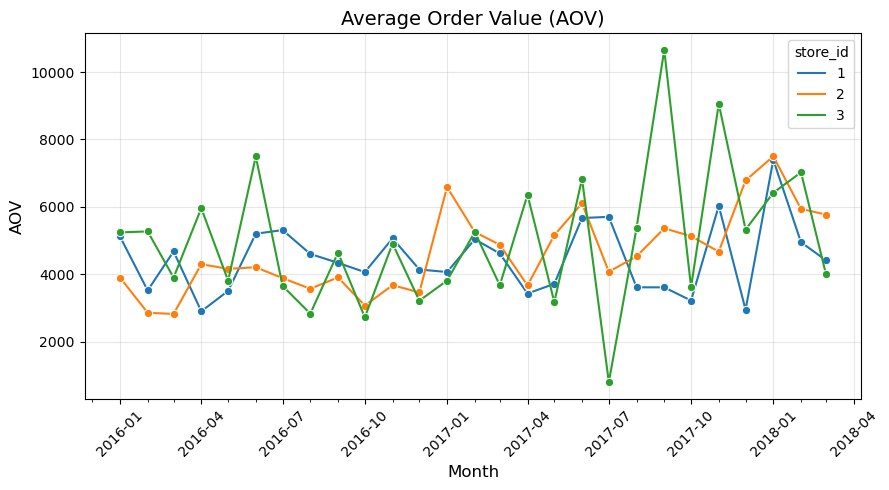

In [94]:
plt.figure(figsize=(9, 5))
sns.lineplot(data=df1, x='month', y='aov',hue='store_id', palette='tab10', marker='o')

# Форматирование оси X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

plt.title('Average Order Value (AOV)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('AOV', fontsize=12)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

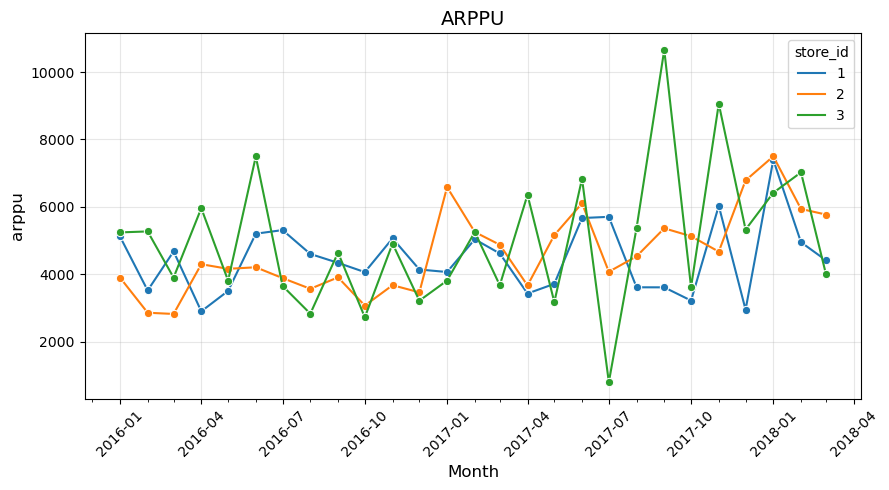

In [95]:
plt.figure(figsize=(9, 5))
sns.lineplot(data=df1, x='month', y='arppu',hue='store_id', palette='tab10', marker='o')

# Форматирование оси X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

plt.title('ARPPU', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('arppu', fontsize=12)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

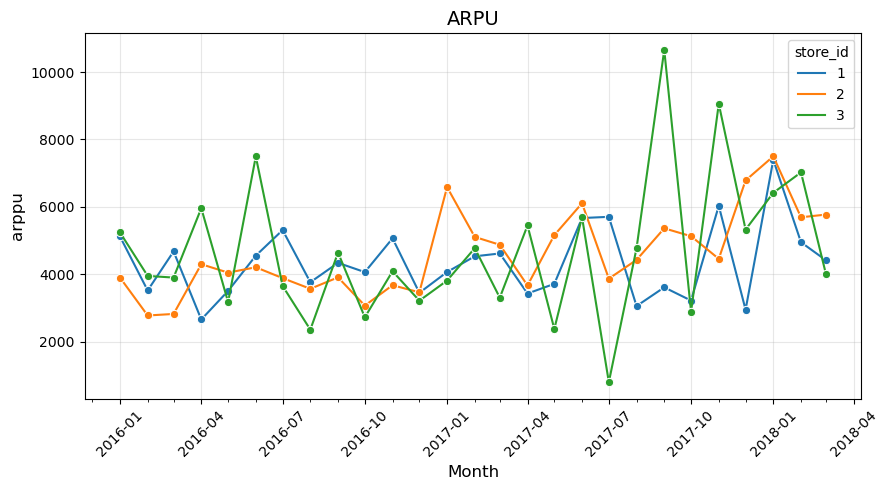

In [96]:
plt.figure(figsize=(9, 5))
sns.lineplot(data=df1, x='month', y='arpu',hue='store_id', palette='tab10', marker='o')

# Форматирование оси X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

plt.title('ARPU', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('arppu', fontsize=12)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

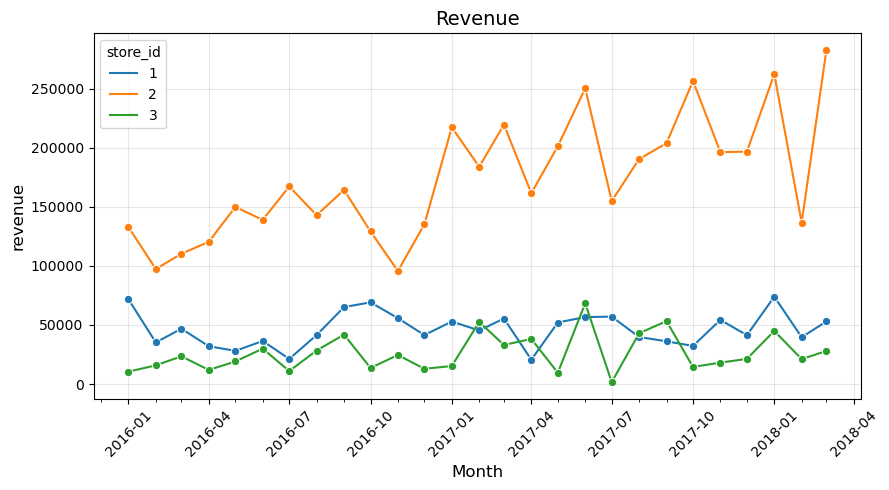

In [102]:
plt.figure(figsize=(9, 5))
sns.lineplot(data=df1, x='month', y='revenue',hue='store_id', palette='tab10', marker='o')

# Форматирование оси X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

plt.title('Revenue', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('revenue', fontsize=12)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Найдем долю отмененных заказов
**order_status** возможные значения:
 1) Pending (В ожидании) 
 2) Processing (В обработке)
 3) Rejected (Отклонено)
 4) Completed (Завершено)

In [104]:
# 3
# cancel_rate
query =\
'''
SELECT store_id, 
        DATE_TRUNC('month', order_date)::DATE AS month,
        ROUND(100 * COUNT(order_id) FILTER(WHERE order_status = 3) / COUNT(*)::DECIMAL, 2) AS cancel_rate
FROM orders
GROUP BY DATE_TRUNC('month', order_date), store_id
ORDER BY store_id, month
'''
#-------------------------------------------------------------------------------------------------------------------------------

response = supabase.rpc('exec_sql', {'query_text': query}).execute()
cancel_df = pd.DataFrame(response.data, columns=['store_id', 'month', 'cancel_rate'])
cancel_df['month'] = cancel_df.month.astype('datetime64[ns]')
print(cancel_df.head())

   store_id      month  cancel_rate
0         1 2016-01-01         0.00
1         1 2016-02-01         0.00
2         1 2016-03-01         0.00
3         1 2016-04-01         8.33
4         1 2016-05-01         0.00


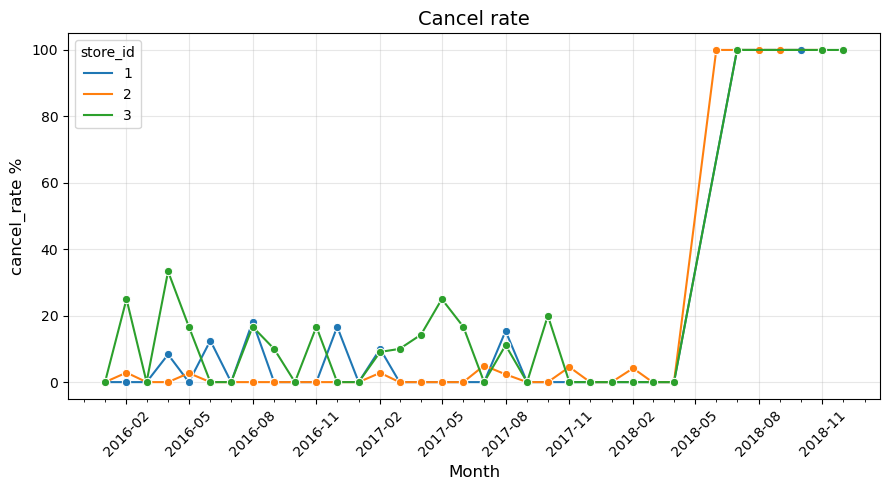

In [107]:
plt.figure(figsize=(9, 5))
sns.lineplot(data=cancel_df, x='month', y='cancel_rate',hue='store_id', palette='tab10', marker='o')

# Форматирование оси X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

plt.title('Cancel rate', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('cancel_rate %', fontsize=12)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Найдем распределение количества статусов заказов по месяцам

In [272]:
# 4

query=\
'''
SELECT DATE_TRUNC('month', order_date)::DATE AS month,
       CASE order_status
           WHEN 1 THEN 'Pending'
           WHEN 2 THEN 'Processing'
           WHEN 3 THEN 'Rejected'
           WHEN 4 THEN 'Completed'
        END AS order_status,
       COUNT(*) AS cnt
FROM orders
GROUP BY DATE_TRUNC('month', order_date)::DATE, order_status
ORDER BY month, order_status
'''
#-------------------------------------------------------------------------------------------------------------------------------

response = supabase.rpc('exec_sql', {'query_text': query}).execute()
status_df = pd.DataFrame(response.data, columns=['month', 'order_status', 'cnt'])
status_df['month'] = pd.to_datetime(status_df['month'], errors='coerce', format='%Y-%m-%d')
print(status_df.head())

       month order_status  cnt
0 2016-01-01    Completed   50
1 2016-02-01    Completed   47
2 2016-02-01     Rejected    2
3 2016-03-01    Completed   55
4 2016-04-01    Completed   41


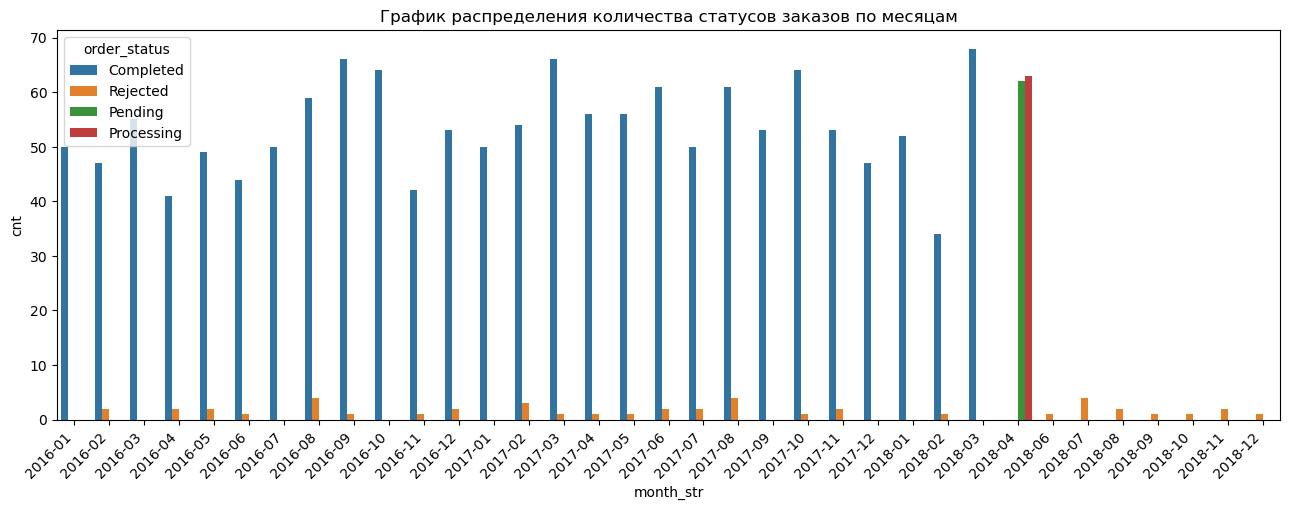

In [283]:
status_df['month_str'] = status_df['month'].dt.strftime('%Y-%m')

plt.figure(figsize=(13, 5))
sns.barplot(data=status_df, x='month_str', y='cnt', hue='order_status')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.title('График распределения количества статусов заказов по месяцам')
plt.show()


---

### Найдем самые продаваемые товары, самые прибыльные товары, а также выручку с различных категорий товаров и бренды, которые в среднем приносят больше денег, чем остальные
#### Для удобства создадим представление (View) cо следующими столбцами
- **product_name** - название товара
- **sold_quantity** - количество проданных штук
- **product_revenue** - выручка с товара
- **category_name** - категория товара
- **brand_name** - бренд

---
Запустить через Jupiter Notebook не получилось, поэтому создал сразу в supabase

#5
```sql
CREATE OR REPLACE VIEW Top_View AS 
  with t1 AS
    (SELECT product_id,
            SUM(quantity) AS sold_quantity,
            SUM(quantity * list_price * (1 - discount)) AS product_revenue
    FROM order_items oi
    WHERE EXISTS(SELECT 1 
                  FROM orders o 
                  WHERE o.order_status = 4
                        AND o.order_id = oi.order_id)
    GROUP BY product_id)
  
  SELECT product_id,
          product_name,
          sold_quantity,
          product_revenue,
          category_name,
          brand_name

  FROM t1 
  LEFT JOIN products 
    USING(product_id)
  LEFT JOIN categories 
    USING(category_id)
  LEFT JOIN brands
    USING(brand_id)
```

In [230]:
# Посмотрим, что получилось
query = \
'''
SELECT *
FROM Top_View
LIMIT 5
'''
#-------------------------------------------------------------------------------------------------------------------------------

response = supabase.rpc('exec_sql', {'query_text': query}).execute()
columns = ['product_id', 'product_name', 'sold_quantity', 'product_revenue', 'category_name', 'brand_name']
pd.DataFrame(response.data, columns=columns)

,product_id,product_name,sold_quantity,product_revenue,category_name,brand_name
0,116,Trek Marlin 7 - 2017/2018,2,1394.9814,Mountain Bikes,Trek
1,184,Trek Domane SL 6 Disc - 2018,3,8399.9760,Road Bikes,Trek
2,87,Trek Precaliber 12 Boys - 2017,29,4795.3476,Children Bicycles,Trek
3,273,Trek Precaliber 20 6-speed Girl's - 2018,1,269.6907,Children Bicycles,Trek
4,51,Trek Silque SLR 8 Women's - 2017,28,168674.7405,Road Bikes,Trek


### 15 самых продаваемых товаров (если кол-во одинаковое, то отбирается в алфавитном порядке)

In [196]:
# 6
# Top 15 sold_quantity
query = \
'''
SELECT product_id, product_name, sold_quantity
FROM Top_View
ORDER BY sold_quantity DESC, product_name
LIMIT 15
'''
#-------------------------------------------------------------------------------------------------------------------------------

response = supabase.rpc('exec_sql', {'query_text': query}).execute()
top_sold = pd.DataFrame(response.data, columns=['product_id', 'product_name', 'sold_quantity'])
top_sold.head()

,product_id,product_name,sold_quantity
0,6,Surly Ice Cream Truck Frameset - 2016,162
1,13,Electra Cruiser 1 (24-Inch) - 2016,155
2,23,Electra Girl's Hawaii 1 (20-inch) - 2015/2016,152
3,16,Electra Townie Original 7D EQ - 2016,151
4,7,Trek Slash 8 27.5 - 2016,151


In [197]:
# Так как с одним и тем же именем могут встречаются разные товары
top_sold['id_name'] = 'id_' + top_sold.product_id.astype(str) + ', ' + top_sold['product_name']

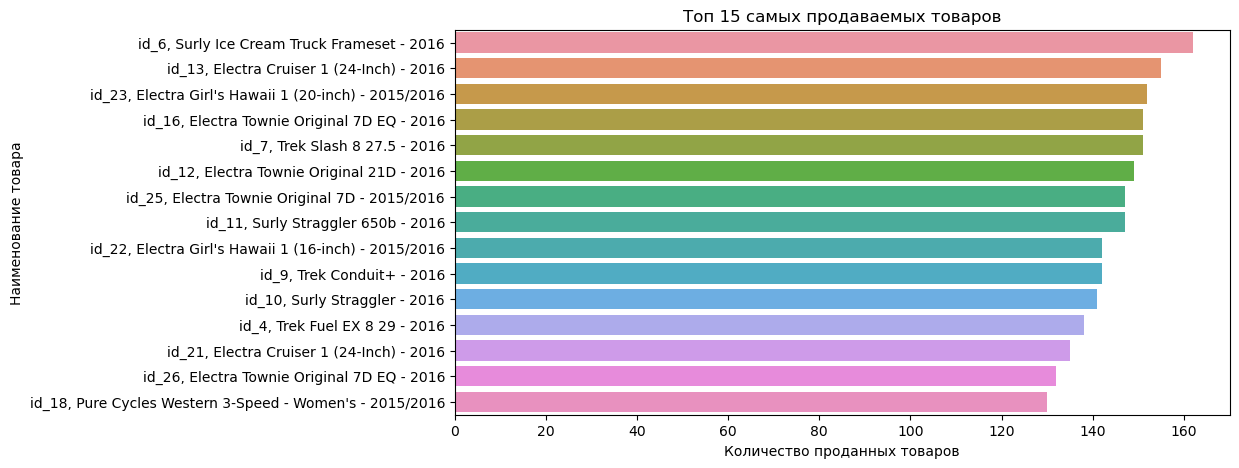

In [198]:
plt.figure(figsize=(10, 5))
sns.barplot(top_sold, y='id_name', x='sold_quantity')
plt.title('Топ 15 самых продаваемых товаров')
plt.xlabel('Количество проданных товаров')
plt.ylabel('Наименование товара')
plt.show()

### Топ 15 товаров по выручке

In [200]:
# 7
query = \
'''
SELECT CONCAT('id_', product_id, ' ', product_name) AS id_name,
        product_revenue
FROM Top_View
ORDER BY product_revenue DESC
LIMIT 15
'''
#-------------------------------------------------------------------------------------------------------------------------------

response = supabase.rpc('exec_sql', {'query_text': query}).execute()
top_revenue = pd.DataFrame(response.data, columns=['id_name', 'product_revenue'])
top_revenue.head()

,id_name,product_revenue
0,id_7 Trek Slash 8 27.5 - 2016,544318.6392
1,id_9 Trek Conduit+ - 2016,381148.7295
2,id_4 Trek Fuel EX 8 29 - 2016,354813.7765
3,id_11 Surly Straggler 650b - 2016,220713.9870
4,id_8 Trek Remedy 29 Carbon Frameset - 2016,199996.8889


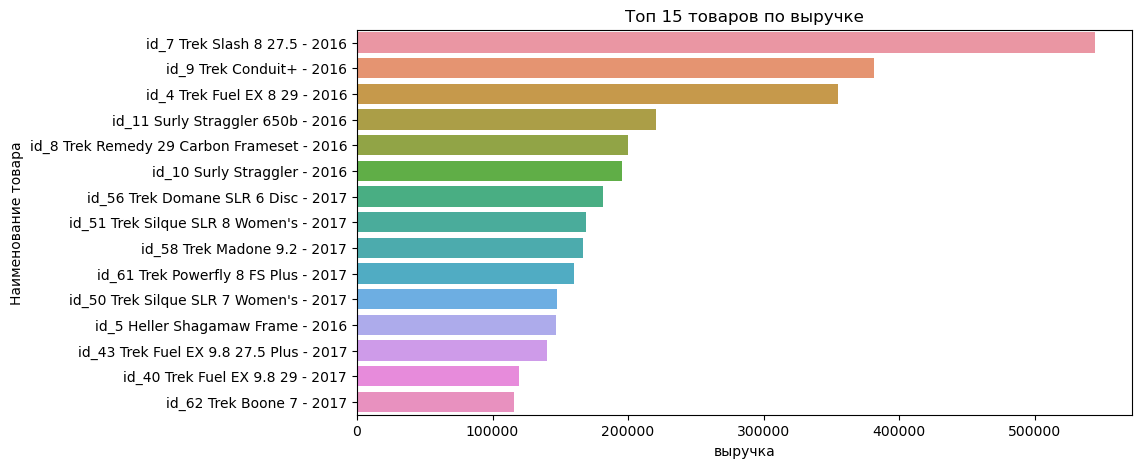

In [202]:
plt.figure(figsize=(10, 5))
sns.barplot(top_revenue, y='id_name', x='product_revenue')
plt.title('Топ 15 товаров по выручке')
plt.xlabel('выручка')
plt.ylabel('Наименование товара')
plt.show()

### Найдем товары, которые есть в топе и по выручке и по количеству продаж

In [345]:
# 8 
query =\
'''
(SELECT id_name
FROM
    (SELECT CONCAT('id_', product_id, ' ', product_name) AS id_name,
            product_revenue
    FROM Top_View
    ORDER BY product_revenue DESC
    LIMIT 15) t1)
    
INTERSECT 

(SELECT id_name
FROM 
    (SELECT CONCAT('id_', product_id, ' ', product_name) AS id_name,
            product_name,
            sold_quantity
    FROM Top_View
    ORDER BY sold_quantity DESC, product_name
    LIMIT 15) t2)
'''
#-------------------------------------------------------------------------------------------------------------------------------

response = supabase.rpc('exec_sql', {'query_text': query}).execute()
top_intersect = pd.DataFrame(response.data)

for num, el in enumerate(top_intersect.id_name, 1):
    print(f'{num}: {el}')

1: id_11 Surly Straggler 650b - 2016
2: id_4 Trek Fuel EX 8 29 - 2016
3: id_10 Surly Straggler - 2016
4: id_9 Trek Conduit+ - 2016
5: id_7 Trek Slash 8 27.5 - 2016


### Посчитаем выручку с разных категорий

In [217]:
#  9
query = \
'''
SELECT category_name, ROUND(SUM(product_revenue)) AS category_revenue
FROM Top_View
GROUP BY category_name
ORDER BY 2
'''
#-------------------------------------------------------------------------------------------------------------------------------
response = supabase.rpc('exec_sql', {'query_text': query}).execute()
category_df = pd.DataFrame(response.data, columns=['category_name', 'category_revenue'])


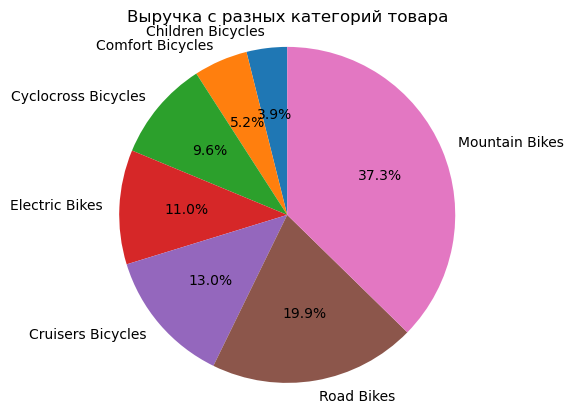

In [226]:
plt.pie(category_df.category_revenue, labels=category_df.category_name, autopct='%1.1f%%', startangle=90)

plt.title('Выручка с разных категорий товара')
plt.axis('equal')
plt.show()

### Найдем бренды, которые в среднем прносят больше денег, чем остальные

In [229]:
# 10
query = \
'''
SELECT brand_name
FROM Top_View
GROUP BY brand_name
HAVING SUM(product_revenue) > (SELECT AVG(brand_revenue)
                                FROM 
                                  (SELECT SUM(product_revenue) AS brand_revenue
                                  FROM Top_View 
                                  GROUP BY brand_name) t)
'''
#-------------------------------------------------------------------------------------------------------------------------------
response = supabase.rpc('exec_sql', {'query_text': query}).execute()
brand_df = pd.DataFrame(response.data)
brand_df

,brand_name
0,Electra
1,Trek
2,Surly


### Найдем для каждого менеджера количество подчиненных
**stuffs** содержит следующие столбцы:
- staff_id (первичный ключ)
- first_name 
- last_name 
- email 
- phone
- active 
- store_id
- manager_id

In [234]:
# 11
query = \
'''
-- найдем работающих на данный момент сотрудников 
WITH active_t AS (
  SELECT staff_id
  FROM staffs
  WHERE active = 1
)

SELECT a.manager_id,
        b.first_name,
        b.last_name,
        COUNT(*) AS subordinates_count
FROM staffs a
LEFT JOIN staffs b
ON a.manager_id = b.staff_id
WHERE a.manager_id IS NOT NULL
      AND a.manager_id IN (SELECT * FROM active_t)
      AND b.staff_id IN (SELECT * FROM active_t)
GROUP BY a.manager_id, b.first_name, b.last_name
ORDER BY 1
'''
#-------------------------------------------------------------------------------------------------------------------------------
response = supabase.rpc('exec_sql', {'query_text': query}).execute()
sub_df = pd.DataFrame(response.data, columns=['manager_id', 'first_name', 'last_name', 'subordinates_count'])
sub_df

,manager_id,first_name,last_name,subordinates_count
0,1,Fabiola,Jackson,3
1,2,Mireya,Copeland,2
2,5,Jannette,David,2
3,7,Venita,Daniel,2


**Сотрудник может быть**
- менеджером, если у него есть хотябы один подчиненным (manager)
- обычным работником, если подчиненных нет (employee)
- Топ менеджером, если не находится ни у кого в подчинении, то есть manager_id IS NULL (top_manager)

Выведем имя сотрудника и его статус

In [341]:
# 12
query = \
'''
SELECT staff_id,
        first_name,
        last_name,
        CASE
            WHEN manager_id IS NOT NULL AND staff_id IN (SELECT DISTINCT manager_id FROM staffs) THEN 'manager'
            WHEN manager_id IS NULL THEN 'top_manager'
            ELSE 'employee' 
        END AS status        
FROM staffs
ORDER BY status DESC, staff_id
'''
#-------------------------------------------------------------------------------------------------------------------------------
response = supabase.rpc('exec_sql', {'query_text': query}).execute()
status = pd.DataFrame(response.data, columns=['staff_id', 'first_name', 'last_name', 'status'])
status

,staff_id,first_name,last_name,status
0,1,Fabiola,Jackson,top_manager
1,2,Mireya,Copeland,manager
2,5,Jannette,David,manager
3,7,Venita,Daniel,manager
4,3,Genna,Serrano,employee
5,4,Virgie,Wiggins,employee
6,6,Marcelene,Boyer,employee
7,8,Kali,Vargas,employee
8,9,Layla,Terrell,employee
9,10,Bernardine,Houston,employee


#### Найдем через сколько дней должна была состояться предполагаемая доставка и через сколько дней товар был доставлен 

In [296]:
# 13
query = \
'''
SELECT DATE_TRUNC('month', order_date) AS month,
        ROUND(AVG(shipped_date - order_date), 2) AS days_to_shipped,
        ROUND(AVG(required_date - order_date), 2) AS required_days,
        ROUND(AVG(shipped_date - required_date), 2) AS diff
FROM orders
WHERE order_status = 4
GROUP BY DATE_TRUNC('month', order_date)
ORDER BY month
'''
#-------------------------------------------------------------------------------------------------------------------------------
response = supabase.rpc('exec_sql', {'query_text': query}).execute()
order_df = pd.DataFrame(response.data, columns=['month', 'days_to_shipped', 'required_days', 'diff'])
order_df.month = pd.to_datetime(order_df.month)
order_df.head()

,month,days_to_shipped,required_days,diff
0,2016-01-01 00:00:00+00:00,1.92,2.14,-0.22
1,2016-02-01 00:00:00+00:00,2.00,2.00,0.00
2,2016-03-01 00:00:00+00:00,1.95,2.20,-0.25
3,2016-04-01 00:00:00+00:00,2.22,1.80,0.41
4,2016-05-01 00:00:00+00:00,1.98,2.02,-0.04


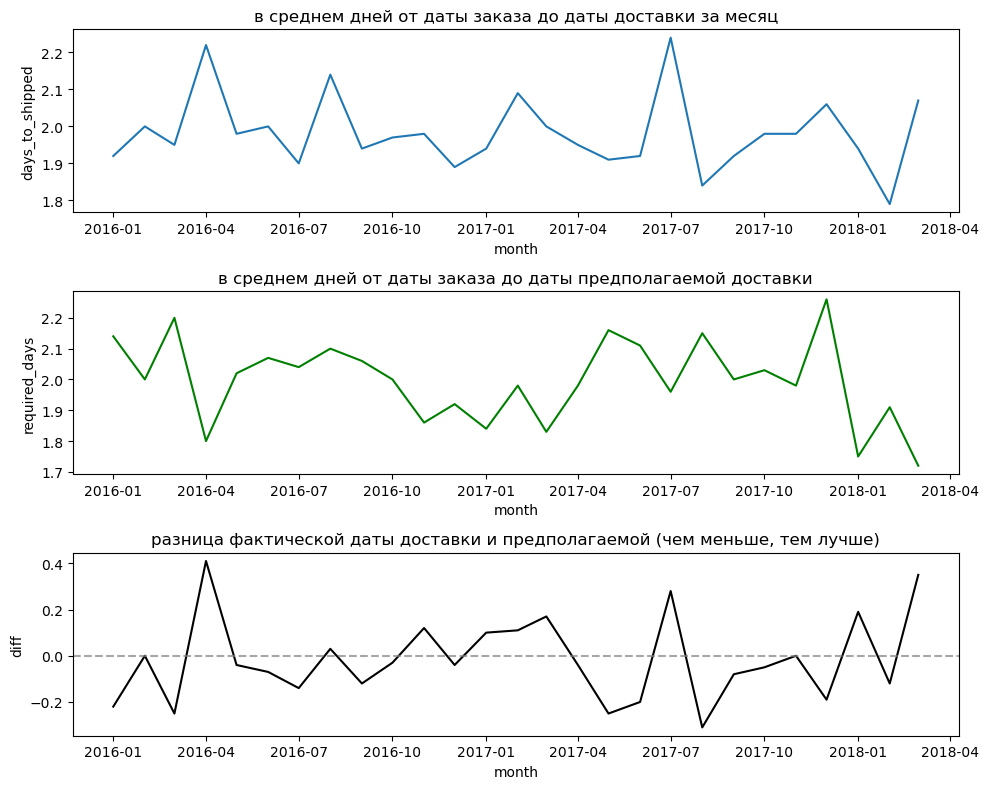

In [315]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

sns.lineplot(data=order_df, x='month', y='days_to_shipped', ax=axes[0])
axes[0].set_title('в среднем дней от даты заказа до даты доставки за месяц')

sns.lineplot(data=order_df, x='month', y='required_days', ax=axes[1], color='green')
axes[1].set_title('в среднем дней от даты заказа до даты предполагаемой доставки')

sns.lineplot(data=order_df, x='month', y='diff', ax=axes[2], color='black')
axes[2].set_title('разница фактической даты доставки и предполагаемой (чем меньше, тем лучше)')
axes[2].axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.tight_layout() 
plt.show()

### Retention

In [346]:
# 14
query =\
'''
WITH t1 AS (
SELECT DISTINCT customer_id,
        store_id,
        DATE_TRUNC('quarter', order_date) AS order_quarter,
        MIN(DATE_TRUNC('quarter', order_date)) OVER(PARTITION BY store_id, customer_id) AS first_quarter
FROM orders)

SELECT store_id,
        first_quarter,
        order_quarter,
        'quarter '|| ((EXTRACT('month' FROM AGE(order_quarter, first_quarter)) +
                EXTRACT('year' FROM AGE(order_quarter, first_quarter)) * 12) / 3)::INT::VARCHAR
                        AS quarter_num,
        ROUND(100 * COUNT(customer_id)::DECIMAL /
                MAX(COUNT(customer_id)) OVER(PARTITION BY store_id, first_quarter), 2) AS retention
FROM t1
GROUP BY store_id, first_quarter, order_quarter
ORDER BY store_id, first_quarter, order_quarter, quarter_num
'''
#-------------------------------------------------------------------------------------------------------------------------------
response = supabase.rpc('exec_sql', {'query_text': query}).execute()
ret_df = pd.DataFrame(response.data, columns=['store_id', 'first_quarter', 'order_quarter', 'quarter_num', 'retention'])
ret_df.first_quarter = pd.to_datetime(ret_df.first_quarter)
ret_df.order_quarter = pd.to_datetime(ret_df.order_quarter)
ret_df.head()

,store_id,first_quarter,order_quarter,quarter_num,retention
0,1,2016-01-01 00:00:00+00:00,2016-01-01 00:00:00+00:00,quarter 0,100.00
1,1,2016-01-01 00:00:00+00:00,2017-07-01 00:00:00+00:00,quarter 6,2.94
2,1,2016-01-01 00:00:00+00:00,2018-04-01 00:00:00+00:00,quarter 9,20.59
3,1,2016-04-01 00:00:00+00:00,2016-04-01 00:00:00+00:00,quarter 0,100.00
4,1,2016-04-01 00:00:00+00:00,2016-07-01 00:00:00+00:00,quarter 1,3.57


Так как повторные покупки совершаются нечасто, посчитаем rolling retention

### Rolling retention

In [339]:
# 15 
query = \
'''
WITH 
-- Найдем для каждого покупателя квартал когда была совершена покупка и первая покупка
t1 AS (
SELECT DISTINCT customer_id,
        store_id,
        DATE_TRUNC('quarter', order_date) AS order_quarter,
        MIN(DATE_TRUNC('quarter', order_date)) OVER(PARTITION BY store_id, customer_id) AS first_quarter
FROM orders),
-- найдем каким по счету является квартал с момента первой покупки
t2 AS (
        SELECT customer_id,
                store_id,
                first_quarter,
                ((EXTRACT('month' FROM AGE(order_quarter, first_quarter)) +
                EXTRACT('year' FROM AGE(order_quarter, first_quarter)) * 12) / 3)::INT
                        AS quarter_num 
        FROM t1
),

-- создадим cte с номерами кварталов. Если квартал в котором была совершена покупка больше или равен номеру квартала
-- из t3, то мы выводим customer_id человека, который совершал покупку.
-- Сгруппировав по id магазина, кварталу первой покупки и номеру квартала,
-- получим количество уникальных человек, которые совершили покупку в данном или последующем квартале

t3 AS (
SELECT DISTINCT quarter_num
FROM t2
),
res_t AS (
SELECT t2.store_id, t2.first_quarter, t3.quarter_num,
        COUNT (DISTINCT (CASE
                            WHEN t2.quarter_num >= t3.quarter_num THEN t2.customer_id
                            END)) AS cnt
FROM t2, t3 
WHERE t3.quarter_num <= ((EXTRACT('month' FROM AGE((SELECT MAX(order_quarter) FROM t1), t2.first_quarter)) +
                EXTRACT('year' FROM AGE((SELECT MAX(order_quarter) FROM t1), t2.first_quarter)) * 12) / 3)::INT


GROUP BY t2.store_id, t2.first_quarter, t3.quarter_num
)
-- Посчитаем rolling_retention
SELECT store_id, first_quarter, quarter_num,
       ROUND(100 * cnt::DECIMAL / (MAX(cnt) OVER(PARTITION BY store_id, first_quarter)), 2) AS rolling_retention
FROM res_t
ORDER BY store_id, first_quarter, quarter_num
'''
#-------------------------------------------------------------------------------------------------------------------------------
response = supabase.rpc('exec_sql', {'query_text': query}).execute()
roll_ret_df = pd.DataFrame(response.data, columns=['store_id', 'first_quarter', 'quarter_num', 'rolling_retention'])
roll_ret_df.first_quarter = pd.to_datetime(roll_ret_df.first_quarter)
roll_ret_df.head()

,store_id,first_quarter,quarter_num,rolling_retention
0,1,2016-01-01 00:00:00+00:00,0,100.00
1,1,2016-01-01 00:00:00+00:00,1,20.59
2,1,2016-01-01 00:00:00+00:00,2,20.59
3,1,2016-01-01 00:00:00+00:00,3,20.59
4,1,2016-01-01 00:00:00+00:00,4,20.59


In [400]:
styled_table = (roll_ret_df.pivot_table(
                    index=['store_id', 'first_quarter'],
                    columns=['quarter_num'],
                    values=['rolling_retention'])
                .style
                .background_gradient(cmap='Blues')
                .set_caption('Rolling Retention по магазинам и кварталам'))
styled_table

### Товары, которые покупают вместе чаще всего

In [349]:
# 16
query = \
'''
WITH t1 AS (
  SELECT a.product_id a_product,
         b.product_id b_product,
         COUNT(*) as cnt
  FROM order_items a
  JOIN order_items b
  ON a.order_id = b.order_id

  WHERE a.product_id > b.product_id
  GROUP BY a.product_id, b.product_id
)

SELECT p1.product_name AS product1,
        p2.product_name AS product2,
        t1.cnt
FROM t1
LEFT JOIN (SELECT product_id, product_name FROM products) p1
ON t1.a_product = p1.product_id
LEFT JOIN (SELECT product_id, product_name FROM products) p2
ON t1.b_product = p2.product_id

ORDER BY cnt DESC, product1
LIMIT 10
'''
#-------------------------------------------------------------------------------------------------------------------------------
response = supabase.rpc('exec_sql', {'query_text': query}).execute()
product_pairs = pd.DataFrame(response.data, columns=['product1', 'product2', 'cnt'])
product_pairs

,product1,product2,cnt
0,Electra Girl's Hawaii 1 (16-inch) - 2015/2016,Heller Shagamaw Frame - 2016,15
1,Electra Cruiser 1 (24-Inch) - 2016,Electra Moto 1 - 2016,14
2,Electra Cruiser 1 (24-Inch) - 2016,Electra Townie Original 21D - 2016,14
3,Surly Straggler 650b - 2016,Trek Conduit+ - 2016,14
4,Electra Cruiser 1 (24-Inch) - 2016,Pure Cycles Western 3-Speed - Women's - 2015/2016,13
5,Electra Girl's Hawaii 1 (20-inch) - 2015/2016,Electra Girl's Hawaii 1 (16-inch) - 2015/2016,13
6,Surly Straggler - 2016,Trek Conduit+ - 2016,13
7,Electra Moto 1 - 2016,Surly Wednesday Frameset - 2016,12
8,Electra Townie Original 7D EQ - 2016,Pure Cycles Vine 8-Speed - 2016,12
9,Pure Cycles Western 3-Speed - Women's - 2015/2016,Trek Fuel EX 8 29 - 2016,12


In [391]:
# Информация о покупателях
# 17
query = \
'''
with Orders_revenue_t AS (
  SELECT order_id,
          SUM(quantity * list_price * (1 - discount)) AS order_revenue
  FROM order_items
  GROUP BY order_id 
),
t1 AS (
SELECT store_id, customer_id, 
        COUNT(order_id) AS count_orders,
        SUM(order_revenue) AS revenue_per_user,
        SUM(order_revenue)::DECIMAL / COUNT(order_id) AS avg_order_price
FROM orders o
LEFT JOIN Orders_revenue_t r
USING(order_id)
WHERE order_status = 4
GROUP BY store_id, customer_id)

SELECT store_name,
        first_name ||' '|| last_name AS name,
        phone, email, city,
        count_orders,
        revenue_per_user,
        ROUND(avg_order_price, 2) AS avg_order_price
FROM t1
LEFT JOIN customers c
USING(customer_id)
LEFT JOIN (SELECT store_id, store_name FROM stores) st
USING(store_id)
ORDER BY revenue_per_user
'''
response = supabase.rpc('exec_sql', {'query_text': query}).execute()
df2 = pd.DataFrame(response.data, columns=['store_name', 'name', 'phone', 'email', 'city', 'count_orders', 'revenue_per_user', 'avg_order_price'])


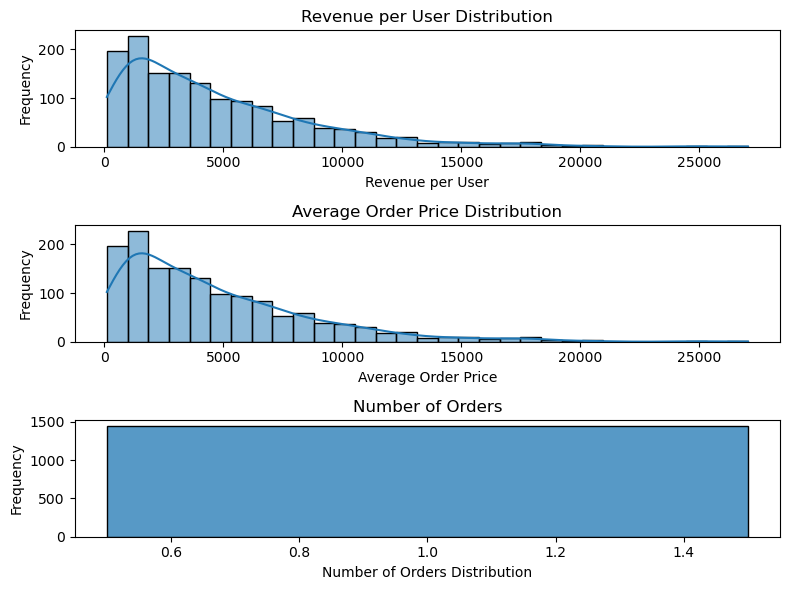

In [392]:

fig, axes = plt.subplots(3, 1, figsize=(8, 6))

# Revenue per user
sns.histplot(df2.revenue_per_user, ax=axes[0], kde=True)
axes[0].set_title('Revenue per User Distribution')
axes[0].set_xlabel('Revenue per User')
axes[0].set_ylabel('Frequency')

# Average order price
sns.histplot(df2.avg_order_price, ax=axes[1], kde=True)
axes[1].set_title('Average Order Price Distribution')
axes[1].set_xlabel('Average Order Price')
axes[1].set_ylabel('Frequency')

# Count of orders
sns.histplot(df2.count_orders, ax=axes[2])
axes[2].set_title('Number of Orders')
axes[2].set_xlabel('Number of Orders Distribution')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [396]:
df2.count_orders.unique()

array([1], dtype=int64)